In [3]:
!pip install QuantumRingsLib
!pip install qiskit==1.3.1
!pip install quantumrings-toolkit-qiskit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 11.8 MB/s eta 0:00:00
  Using cached qiskit-1.3.1-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
  Using cached rustworkx-0.16.0-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (10 kB)
  Using cached dill-0.3.9-py3-none-any.whl.metadata (10 kB)
  Using cached stevedore-5.4.1-py3-none-any.whl.metadata (2.3 kB)
  Using cached symengine-0.13.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.2 kB)
  Using cached pbr-6.1.1-py2.py3-none-any.whl.metadata (3.4 kB)
Using cached qiskit-1.3.1-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (6.7 MB)
Using cached dill-0.3.9-py3-none-any.whl (119 kB)
Using cached rustworkx-0.16.0-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.1 MB)
Using cached stevedore-5.4.1-py3-none-any.whl (49 kB)
Using cached symengine-0.13.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (49.7 MB)
Using cached pbr-6.1.1-py

In [38]:
from qiskit import QuantumCircuit, transpile, QuantumRegister, ClassicalRegister, AncillaRegister
from qiskit.visualization import plot_histogram
from matplotlib import pyplot as plt
import numpy as np

from QuantumRingsLib import QuantumRingsProvider
from quantumrings.toolkit.qiskit import QrBackendV2

In [5]:
#Acquire the Quantum Rings Provider
provider = QuantumRingsProvider(
    token='rings-128.tFp5jv833mIYtWvhAcPilxZNHO0MGRw1',
    name='khang.tran@princeton.edu'
)
print("Account Name: ", provider.active_account()["name"], "\nMax Qubits: ", provider.active_account()["max_qubits"])


#Save the account locally.
provider.save_account(
    token='rings-128.tFp5jv833mIYtWvhAcPilxZNHO0MGRw1',
    name='khang.tran@princeton.edu')
print(provider.saved_accounts(False, "default"))

Account Name:  khang.tran@princeton.edu 
Max Qubits:  128
{'khang.tran@princeton.edu': 'rings-128.tFp5jv833mIYtWvhAcPilxZNHO0MGRw1'}


In [6]:
def egcd(a, b):
    if a == 0:
        return (b, 0, 1)
    else:
        g, y, x = egcd(b % a, a)
        return (g, x - (b // a) * y, y)

def modinv(a, m):
    g, x, y = egcd(a, m)
    if g != 1:
        raise Exception('modular inverse does not exist')
    else:
        return x % m

In [7]:
def getAngles(a,N):
    s=bin(int(a))[2:].zfill(N)
    angles=np.zeros([N])
    for i in range(0, N):
        for j in range(i,N):
            if s[j]=='1':
                angles[N-i-1]+=np.power(2.0, -(j-i))
        angles[N-i-1]*=np.pi
    return angles

"""Creation of a doubly controlled phase gate"""
def ccphase(circuit,angle,ctl1,ctl2,tgt):
    # TODO: check if this is the same
    #circuit.cu1(angle/2,ctl1,tgt)
    circuit.cp(angle/2,ctl1,tgt)
    circuit.cx(ctl2,ctl1)
    #circuit.cu1(-angle/2,ctl1,tgt)
    circuit.cp(-angle/2,ctl1,tgt)
    circuit.cx(ctl2,ctl1)
    #circuit.cu1(angle/2,ctl2,tgt)
    circuit.cp(angle/2,ctl2,tgt)

In [8]:
def create_QFT(circuit : QuantumCircuit, up_reg : QuantumRegister, n, with_swaps):
    i = n - 1
    """ Apply the H gates and Cphases"""
    """ The Cphases with |angle| < threshold are not created because they do
    nothing. The threshold is put as being 0 so all CPhases are created,
    but the clause is there so if wanted just need to change the 0 of the
    if-clause to the desired value """
    while i >= 0:
        circuit.h(up_reg[i])
        j = i - 1
        while j >= 0:
            if (np.pi) / (pow(2, (i - j))) > 0:
                # TODO: check cp cu1
                #circuit.cu1((np.pi) / (pow(2, (i - j))), up_reg[i], up_reg[j])
                circuit.cp((np.pi) / (pow(2, (i - j))), up_reg[i], up_reg[j])
                j = j - 1
        i = i - 1

    """ If specified, apply the Swaps at the end """
    if with_swaps == 1:
        i = 0
        while i < ((n - 1) / 2):
            circuit.swap(up_reg[i], up_reg[n - 1 - i])
            i = i + 1

def create_inverse_QFT(circuit, up_reg, n, with_swaps):
    """If specified, apply the Swaps at the beggining"""
    if with_swaps == 1:
        i = 0
        while i < ((n - 1) / 2):
            circuit.swap(up_reg[i], up_reg[n - 1 - i])
            i = i + 1

    """ Apply the H gates and Cphases"""
    """ The Cphases with |angle| < threshold are not created because they do
    nothing. The threshold is put as being 0 so all CPhases are created,
    but the clause is there so if wanted just need to change the 0 of the
    if-clause to the desired value """
    i = 0
    while i < n:
        circuit.h(up_reg[i])
        if i != n - 1:
            j = i + 1
            y = i
            while y >= 0:
                if (np.pi) / (pow(2, (j - y))) > 0:
                    # TODO: check cu1 u1
                    #circuit.cu1(-(np.pi) / (pow(2, (j - y))), up_reg[j], up_reg[y])
                    circuit.cp(-(np.pi) / (pow(2, (j - y))), up_reg[j], up_reg[y])
                    y = y - 1
        i = i + 1

In [9]:
"""Creation of the circuit that performs addition by a in Fourier Space"""

"""Can also be used for subtraction by setting the parameter inv to a value different from 0"""


def phiADD(circuit, q, a, N, inv):
    angle = getAngles(a, N)
    for i in range(0, N):
        # TODO: check u1 p
        if inv == 0:
            #circuit.u1(angle[i], q[i])
            circuit.p(angle[i], q[i])
        else:
            #circuit.u1(-angle[i], q[i])
            circuit.p(-angle[i], q[i])


"""Single controlled version of the phiADD circuit"""


def cphiADD(circuit, q, ctl, a, n, inv):
    angle = getAngles(a, n)
    for i in range(0, n):
        # TODO: check cp cu1
        if inv == 0:
            #circuit.cu1(angle[i], ctl, q[i])
            circuit.cp(angle[i], ctl, q[i])
        else:
            #circuit.cu1(-angle[i], ctl, q[i])
            circuit.cp(-angle[i], ctl, q[i])


"""Doubly controlled version of the phiADD circuit"""


def ccphiADD(circuit, q, ctl1, ctl2, a, n, inv):
    angle = getAngles(a, n)
    for i in range(0, n):
        if inv == 0:
            ccphase(circuit, angle[i], ctl1, ctl2, q[i])
        else:
            ccphase(circuit, -angle[i], ctl1, ctl2, q[i])


"""Circuit that implements doubly controlled modular addition by a"""


def ccphiADDmodN(circuit, q, ctl1, ctl2, aux, a, N, n):
    ccphiADD(circuit, q, ctl1, ctl2, a, n, 0)
    phiADD(circuit, q, N, n, 1)
    create_inverse_QFT(circuit, q, n, 0)
    circuit.cx(q[n - 1], aux)
    create_QFT(circuit, q, n, 0)
    cphiADD(circuit, q, aux, N, n, 0)

    ccphiADD(circuit, q, ctl1, ctl2, a, n, 1)
    create_inverse_QFT(circuit, q, n, 0)
    circuit.x(q[n - 1])
    circuit.cx(q[n - 1], aux)
    circuit.x(q[n - 1])
    create_QFT(circuit, q, n, 0)
    ccphiADD(circuit, q, ctl1, ctl2, a, n, 0)


"""Circuit that implements the inverse of doubly controlled modular addition by a"""


def ccphiADDmodN_inv(circuit, q, ctl1, ctl2, aux, a, N, n):
    ccphiADD(circuit, q, ctl1, ctl2, a, n, 1)
    create_inverse_QFT(circuit, q, n, 0)
    circuit.x(q[n - 1])
    circuit.cx(q[n - 1], aux)
    circuit.x(q[n - 1])
    create_QFT(circuit, q, n, 0)
    ccphiADD(circuit, q, ctl1, ctl2, a, n, 0)
    cphiADD(circuit, q, aux, N, n, 1)
    create_inverse_QFT(circuit, q, n, 0)
    circuit.cx(q[n - 1], aux)
    create_QFT(circuit, q, n, 0)
    phiADD(circuit, q, N, n, 0)
    ccphiADD(circuit, q, ctl1, ctl2, a, n, 1)

In [10]:
def cMULTmodN(circuit : QuantumCircuit, ctl, q, aux, a, semiprime, circuit_size):
    create_QFT(circuit,aux,circuit_size+1,0)
    """Circuit that implements single controlled modular multiplication by a"""
    for i in range(0, circuit_size):
        ccphiADDmodN(circuit, aux, q[i], ctl, aux[circuit_size+1], (2**i)*a % semiprime, semiprime, circuit_size+1)
    create_inverse_QFT(circuit, aux, circuit_size+1, 0)

    for i in range(0, circuit_size):
        circuit.cswap(ctl,q[i],aux[i])

    a_inv = modinv(a, semiprime)
    create_QFT(circuit, aux, circuit_size+1, 0)
    i = circuit_size - 1
    while i >= 0:
        ccphiADDmodN_inv(circuit, aux, q[i], ctl, aux[circuit_size+1], np.power(2,i) * a_inv % semiprime, semiprime, circuit_size+1)
        i -= 1
    create_inverse_QFT(circuit, aux, circuit_size+1, 0)


In [22]:
semiprime = 15
base = 2 # TODO: implement coprime checker
circuit_size = np.ceil(np.log2(semiprime)).astype(int)

In [23]:
# auxilliary quantum register used in addition and multiplication
aux = QuantumRegister(circuit_size+2)
# quantum register where the sequential QFT is performed
up_reg = QuantumRegister(2*circuit_size)
# quantum register where the multiplications are made
down_reg = QuantumRegister(circuit_size)
# classical register where the measured values of the QFT are stored
up_classic = ClassicalRegister(2*circuit_size)

In [24]:
circuit = QuantumCircuit(down_reg, up_reg, aux, up_classic)
# Initialize down register to 1 and create maximal superposition in top register
circuit.h(up_reg)
circuit.x(down_reg[0])

In [25]:
# Apply the multiplication gates as showed in the report in order to create the exponentiation """
for i in range(0, 2*circuit_size):
    cMULTmodN(circuit, up_reg[i], down_reg, aux, int(pow(base, pow(2, i))), semiprime, circuit_size)

In [26]:
# Apply inverse QFT
create_inverse_QFT(circuit, up_reg, 2 * circuit_size, 1)

In [27]:
# Measure the top qubits, to get period
circuit.measure(up_reg,up_classic)

In [28]:
circuit.num_qubits

18

In [29]:
# transpile circuit to Quantum Rings backend
qr_backend = QrBackendV2(provider, num_qubits = circuit.num_qubits)
qc_transpiled = transpile(circuit, qr_backend, initial_layout=[i for i in range(0, circuit.num_qubits)])

In [30]:
# Execute the quantum code
shots = 1024
job = qr_backend.run(qc_transpiled, shots)

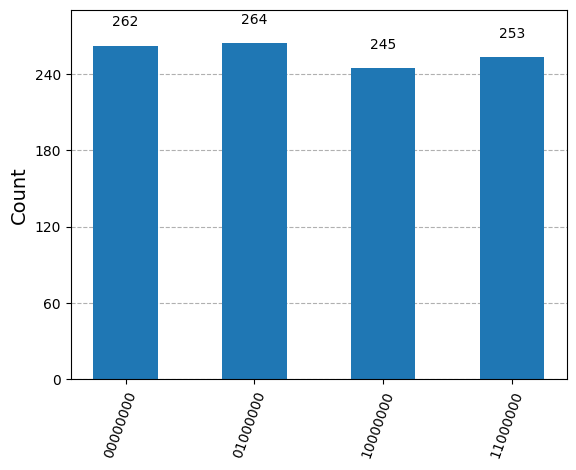

In [31]:
result = job.result()
counts = result.get_counts()
plot_histogram(counts)

In [36]:
counts.keys()

dict_keys(['00000000', '01000000', '10000000', '11000000'])

In [ ]:
def get_factors(x_value,t_upper,N,a):

    if x_value<=0:
        print('x_value is <= 0, there are no continued fractions\n')
        return False

    print('Running continued fractions for this case\n')

    """ Calculate T and x/T """
    T = pow(2,t_upper)

    x_over_T = x_value/T

    """ Cycle in which each iteration corresponds to putting one more term in the
    calculation of the Continued Fraction (CF) of x/T """

    """ Initialize the first values according to CF rule """
    i=0
    b = array.array('i')
    t = array.array('f')

    b.append(math.floor(x_over_T))
    t.append(x_over_T - b[i])

    while i>=0:

        """From the 2nd iteration onwards, calculate the new terms of the CF based
        on the previous terms as the rule suggests"""

        if i>0:
            b.append( math.floor( 1 / (t[i-1]) ) )
            t.append( ( 1 / (t[i-1]) ) - b[i] )

        """ Calculate the CF using the known terms """

        aux = 0
        j=i
        while j>0:
            aux = 1 / ( b[j] + aux )
            j = j-1

        aux = aux + b[0]

        """Get the denominator from the value obtained"""
        frac = fractions.Fraction(aux).limit_denominator()
        den=frac.denominator

        print('Approximation number {0} of continued fractions:'.format(i+1))
        print("Numerator:{0} \t\t Denominator: {1}\n".format(frac.numerator,frac.denominator))

        """ Increment i for next iteration """
        i=i+1

        if (den%2) == 1:
            if i>=15:
                print('Returning because have already done too much tries')
                return False
            print('Odd denominator, will try next iteration of continued fractions\n')
            continue

        """ If denominator even, try to get factors of N """

        """ Get the exponential a^(r/2) """

        exponential = 0

        if den<1000:
            exponential=pow(a , (den/2))

        """ Check if the value is too big or not """
        if math.isinf(exponential)==1 or exponential>1000000000:
            print('Denominator of continued fraction is too big!\n')
            aux_out = input('Input number 1 if you want to continue searching, other if you do not: ')
            if aux_out != '1':
                return False
            else:
                continue

        """If the value is not to big (infinity), then get the right values and
        do the proper gcd()"""

        putting_plus = int(exponential + 1)

        putting_minus = int(exponential - 1)

        one_factor = math.gcd(putting_plus,N)
        other_factor = math.gcd(putting_minus,N)

        """ Check if the factors found are trivial factors or are the desired
        factors """

        if one_factor==1 or one_factor==N or other_factor==1 or other_factor==N:
            print('Found just trivial factors, not good enough\n')
            """ Check if the number has already been found, use i-1 because i was already incremented """
            if t[i-1]==0:
                print('The continued fractions found exactly x_final/(2^(2n)) , leaving funtion\n')
                return False
            if i<15:
                aux_out = input('Input number 1 if you want to continue searching, other if you do not: ')
                if aux_out != '1':
                    return False
            else:
                """ Return if already too much tries and numbers are huge """
                print('Returning because have already done too many tries\n')
                return False
        else:
            print('The factors of {0} are {1} and {2}\n'.format(N,one_factor,other_factor))
            print('Found the desired factors!\n')
            return True

In [34]:
i=0
while i < len(counts):

    """ Get the x_value from the final state qubits """
    output_desired = list(counts.keys())[i]
    x_value = int(output_desired, 2)
    prob_this_result = 100 * ( int( list(counts.values())[i] ) ) / (shots)

    print("------> Analysing result {0}. This result happened in {1:.4f} % of all cases\n".format(output_desired,prob_this_result))

    """ Print the final x_value to user """
    print('In decimal, x_final value for this result is: {0}\n'.format(x_value))

    """ Get the factors using the x value obtained """
    success = get_factors(int(x_value),int(2 * circuit_size),int(semiprime),int(base))

    if success==True:
        prob_success = prob_success + prob_this_result

    i=i+1

print("\nUsing a={0}, found the factors of N={1} in {2:.4f} % of the cases\n".format(base,semiprime,prob_success))

NameError: name 'counts_result' is not defined